## Calcul de $\pi$

Implémenter le calcul de $\pi$ par la méthode de Monte Carlo

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:00<00:00, 166865.08it/s]


Approximation de pi après 100000 tirages : 3.13304


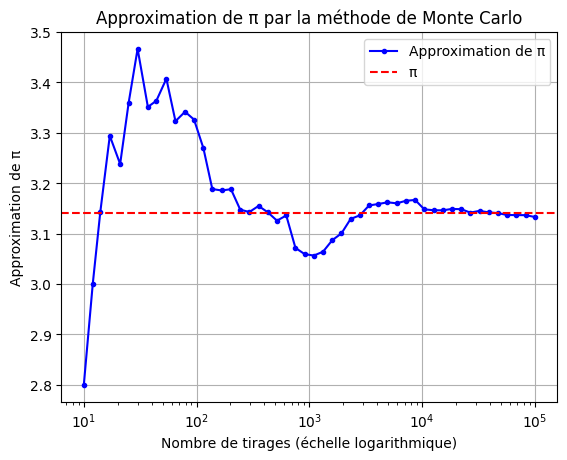

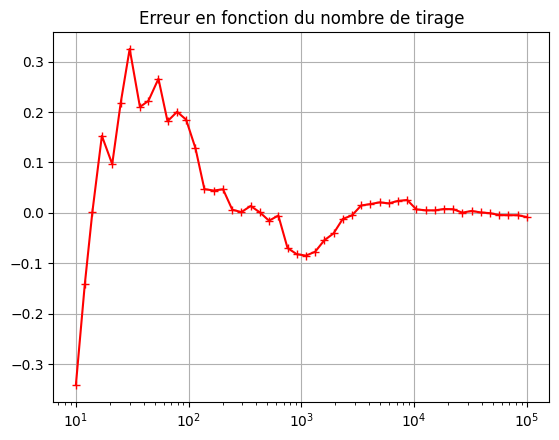

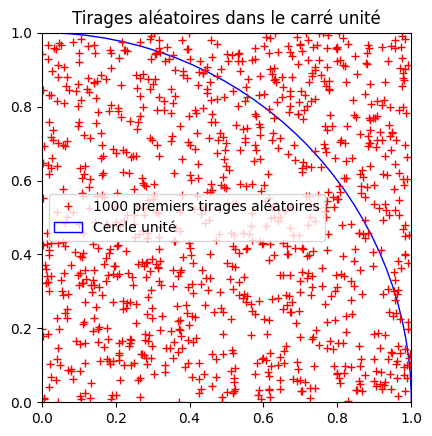

In [14]:
import numpy as np  
import matplotlib.pyplot as plt
from tqdm import tqdm


np.random.seed(0)
nombre_de_tirages = int(1e5)

# Preparer une echelle log pour l'affichage de pi par la methode de Monte Carlo
Tx=np.logspace(1, np.log10(nombre_de_tirages-1), num=50, dtype=int)
Ty=np.zeros_like(Tx, dtype=float)
T_mesure = []
# On va compter le nombre de bon tirage
nombre_de_bons_tirages = 0
for i in tqdm(range(nombre_de_tirages)): 
    # On procède à deux tirages entre 0 et 1 avec une valeur uniforme
    x,y= np.random.uniform(0,1,2) 
    if len(T_mesure)<1000:
        T_mesure.append((x,y))
    # Si la norme est inférieur à 1, alors on est dans le cercle donc le tirage est bon
    if x**2 + y**2 <= 1:
        nombre_de_bons_tirages += 1

    # Stockage des valeurs pour l'affichage de l'évolution de l'approximation
    if i in Tx:
        Ty[np.where(Tx==i)[0][0]] =  4 * nombre_de_bons_tirages / i

pi_approximation = 4 * nombre_de_bons_tirages / nombre_de_tirages
print("Approximation de pi après", nombre_de_tirages, "tirages :", pi_approximation)

# Ty = Ty - np.pi
plt.figure()
plt.xscale('log')
plt.plot(Tx, Ty, marker='.', linestyle='-', color='b', label='Approximation de π')
plt.axhline(np.pi, color='r', linestyle='--', label='π')
plt.xlabel('Nombre de tirages (échelle logarithmique)')
plt.ylabel('Approximation de π')
plt.title('Approximation de π par la méthode de Monte Carlo')
plt.legend()
plt.grid()
plt.show(block=False)

# Affichage de l'erreur en fonction du nombre de tirages
erreur = Ty-np.pi
plt.plot(Tx,erreur,'r+-')
plt.xscale('log')
plt.grid()
plt.title("Erreur en fonction du nombre de tirage")
# plt.legend()
plt.show(block=False)

plt.plot([mesure[0] for mesure in T_mesure], [mesure[1] for mesure in T_mesure], 'r+' )
circle = plt.Circle((0, 0), 1, color='b', fill=False)
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Tirages aléatoires dans le carré unité")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(['1000 premiers tirages aléatoires', 'Cercle unité'])
plt.show(block=False)

# La méthode Monte Carlo appliquée au transport de particules

Considérons la configuration suivante 
- Une géométrie sphérique de rayon $R$.  
- Un matériau contenant un seul isotope (U235) dont les sections et la densité sont données dans la classe `NuclearData`. 

L'exercice consiste à construire une simulation Monte Carlo afin de 
1. Déterminer le $keff$ pour un rayon $R=1$.  
2. Déterminer le rayon critique; $R$ tel que $keff=1$.
3. Déterminer la masse critique
4. Pour le rayon critique, calculer et tracer le flux en fonction du rayon, et estimer les fuites du système.  
5. Tracer le keff en fontion du nombre de batch, Après combien de générations a-t-on atteint la stationnarité ?  
Expliquer l’origine de la non-stationnarité lors des premières générations simulées.

Pour cela, nous considérerons que 
- le noyau ne possède que 3 réactions : Fission, Capture et diffusion.  
- Le système est "mono-cinétique";  i.e. les neutrons ne changent pas d'énergie et les sections ont toujours la même valeur.
- Les neutrons sont placés initialement au centre de la sphère (on peut la considérer centrée en (0,0,0))

Ensuite, vous pouvez implémenter la simulation de la vie d'un neutron (vol, fuite, collision) pour enfin organiser le système selon la "boucle critique". 
Pour cela, vous pouvez vous appuyez sur les classes (partiellement) définies ci-dessous : `NuclearData`, `GeometrySphere`, `Neutron`.   
Quelques fonctions ont été "définies" (mais vide), je vous conseille de les remplir et les utiliser afin de structurer votre code.  
Ces fonctions sont : `sample_interaction`, `sample_uniform_direction`, `get_distance_to_boundary`, `sample_distance_to_interaction`, `simulate_neutron`.  

Les fonctions suivantes de numpy pourraient être utiles : `np.random.uniform`, `np.roots`, les fonctions classiques (`np.cos`, `np.log`, ....), `np.mean` et `np.std` (utiliser l'option `ddof=1` pour la correction de Bessel).

## Quelques données 

In [2]:
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm
import multiprocessing
from multiprocessing import Pool
processes=multiprocessing.cpu_count()


@dataclass
class NuclearData:
    atomic_weight_ratio: float = 235.0
    density: float = 4.4994e-02  # at. / barn.cm
    xs_capture: float = 0.0599268
    xs_elastic: float = 3.78266
    xs_fission: float = 1.2885
    nu_bar: float = 2.64574
    xs_total: float = field(init=False)

    def __post_init__(self):
        self.xs_total = self.xs_capture + self.xs_elastic + self.xs_fission

    def get_macro_xs(self, reaction):
        return self.density * self.get_xs(reaction)

    def get_xs(self, reaction):
        if reaction.lower() == "capture":
            return self.xs_capture
        if reaction.lower() == "fission":
            return self.xs_fission
        if reaction.lower() == "elastic":
            return self.xs_elastic
        if reaction.lower() == "total":
            return self.xs_total
        raise ValueError(
            f"Reaction {reaction} is not accepted. Accepted values are: capture, fission, elastic, total"
        )

    def sample_interaction(self):
        """ Select the interaction : return string : 'capture', ... 
        """
        interactions=['capture', 'fission', 'elastic']
        probabilities=[self.xs_capture/self.xs_total, self.xs_fission/self.xs_total, self.xs_elastic/self.xs_total]
        return np.random.choice(interactions, p=probabilities)


def sample_uniform_direction():
    """ Sample a uniform direction 
    """
    vec = np.random.uniform(-1, 1, 3)
    return vec / np.linalg.norm(vec)  



@dataclass
class GeometrySphere:
    radius: float = 1.0
    center: np.ndarray = field(default_factory=lambda: np.zeros(3))
    
    def neutron_in_sphere(self, pos):
        """Est ce que le neutron est dans la sphère

        Args:
            pos (np.ndarray): _position du neutron_

        Returns:
            boolean: True ou False
        """
        distance = np.linalg.norm(pos - self.center)  
        if distance < self.radius:
            return True
        return False

@dataclass
class Neutron:
    position: np.ndarray
    direction: np.ndarray

    def __post_init__(self):
        self._normalize_direction()

    def _normalize_direction(self):
        norm = np.linalg.norm(self.direction)
        self.direction /= norm
    
    def set_direction(self, vec):
        self.direction = vec
        self._normalize_direction()

    def move_distance(self, distance):
        self.position += self.direction * distance

def sample_distance_to_interaction(sigma_t):
    """
    Sample the distance to the next interaction from the total cross section
    """
    return -1/sigma_t * np.log(1-np.random.rand())

def simulate_neutron(neutron):
    """
    Simulate the life of a neutron. 
    Eventually return fission neutrons in a list if a fission happened
    """

    # On choisit l'interaction
    distance = sample_distance_to_interaction(data.get_macro_xs("total"))
    neutron.move_distance(distance)

    interaction=data.sample_interaction()
    while interaction == 'elastic':
        distance = sample_distance_to_interaction(data.get_macro_xs("total"))
        neutron.move_distance(distance)

        # On verifie si le neutron est sorti de la boule
        if geometry.neutron_in_sphere(neutron.position)==False:
            return [] # Si il est sorti, il est mort

        # On choisit la nouvelle direction
        neutron.set_direction(sample_uniform_direction())
        interaction = data.sample_interaction()
    
    
    if interaction=='fission': # Si c'est une fission, on crée de nouveaux neutrons
        new_neutron=[Neutron(neutron.position.copy(), sample_uniform_direction()) for _ in range(np.random.poisson(data.nu_bar))]
        return new_neutron
    
    if interaction=='capture': # Si c'est une capture, le neutron disparait
        return []
    
    assert False, "Erreur, pas d'interaction"


# rayon pour démarrer
rayon = 8.44  # cm
np.random.seed(0)

data = NuclearData()
geometry = GeometrySphere(radius=rayon)
nb_neutrons_per_batch = 10000
nb_batches = 50 # 110
starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction()) for i in range(nb_neutrons_per_batch)]
keff = np.zeros(nb_batches)

# for i in tqdm(range(nb_batches)):
#     output_neutrons = []

#     for neutron in starting_neutrons:
#         new_neutrons = simulate_neutron(neutron)
#         output_neutrons += new_neutrons

#     # with Pool(processes) as pool:
#     #     results = pool.map(simulate_neutron, starting_neutrons)
#     # output_neutrons = [n for sub in results for n in sub]

#     keff[i] = len(output_neutrons) / nb_neutrons_per_batch
#     # print(f"Generation {i}: keff = {keff[i]} avec {len(output_neutrons)} neutrons")

#     starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]

def calculer_keff(rayon, nb_batches=250, nb_neutrons_per_batch=10000):
    """ Calcul de keff pour une sphère de rayon donné

    Args:
        rayon (float): rayon de la sphère
        nb_batches (int, optional): nombre de lots. Defaults to 110.
        nb_neutrons_per_batch (int, optional): nombre de neutrons par lot. Defaults to 10000.
    """
    np.random.seed(0)

    starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction()) for i in range(nb_neutrons_per_batch)]
    keff = np.zeros(nb_batches)
    global data, geometry
    data = NuclearData()
    geometry = GeometrySphere(radius=rayon)

    # for i in tqdm(range(nb_batches)): # Affichage de la barre de progression
    for i in range(nb_batches):
        output_neutrons = []

        # # on fait évoluer chaque neutron (méthode non parallélisée)
        # for neutron in starting_neutrons:
        #     new_neutrons = simulate_neutron(neutron)
        #     output_neutrons += new_neutrons

        # Parallélisation des calculs
        with Pool(processes) as pool:
            results = pool.map(simulate_neutron, starting_neutrons)
        output_neutrons = [n for sub in results for n in sub]

        keff[i] = len(output_neutrons) / nb_neutrons_per_batch

        # deepcopy qui est plus efficace que copy et qui résoud les problèmes de références
        starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]

    moyenne_keff = np.mean(keff[:])  # Moyenne
    ecart_type_keff = np.std(keff[:],ddof=1) # Ecart type
    return moyenne_keff, ecart_type_keff


# Evolution de $k_{eff}$ en fonction du nombre de batch

On commence par essayer notre fonction qui permet de voir l'évolution de $k_{eff}$.
D'après internet, la masse critique d'U235 est de 48kg ce qui revient à une sphère de 8.44 cm. On va donc vérifier si $k_{eff}=1$ avec une sphère de 8.44 cm.

100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


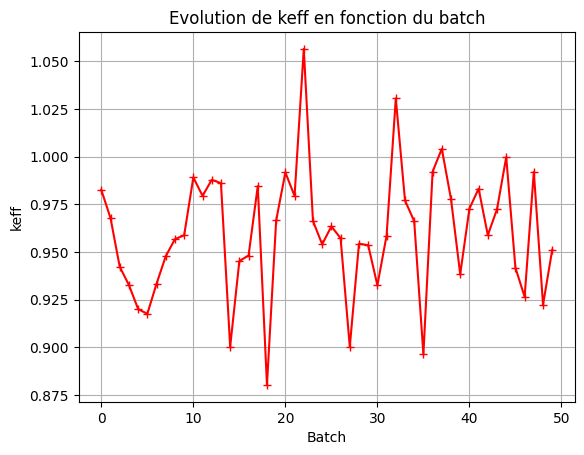

In [4]:
rayon = 8.44 
for i in tqdm(range(nb_batches)):
    output_neutrons = []

    # for neutron in starting_neutrons:
    #     new_neutrons = simulate_neutron(neutron)
    #     output_neutrons += new_neutrons

    with Pool(processes) as pool:
        results = pool.map(simulate_neutron, starting_neutrons)
    output_neutrons = [n for sub in results for n in sub]

    keff[i] = len(output_neutrons) / nb_neutrons_per_batch

    starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]

plt.plot(keff,'r+-')
plt.xlabel("Batch")
plt.ylabel("keff")
plt.title("Evolution de keff en fonction du batch")
plt.grid()
plt.show()

On trouve bien un k qui tend vers 1 (approximativement et avec un bruit important car c'est k exact à chaque pas de calcul).

On peut aussi vérifier que si on tend vers un rayon infini, on a k qui en majoré par $ \nu $. Cela est fait ci dessous en tracant le k moyen et son écart type pour plusieurs valeur de rayon.

Comme le calcul a durée plusieurs heures, j'ai d'abord enregistré les valeurs avant de l'afficher pour éviter d'avoir à les refaire.

In [ ]:
# Trayon = np.arange(6,10.5,0.1)
Trayon=list(np.arange(1,7,1))+list(np.arange(7,10,0.1))+list(np.arange(10,20,1))+list(np.arange(20,110,10))
Tkeff=[]
for rayon in Trayon:
    # print("Calcul de keff pour un rayon de {:.1f} cm".format(rayon))
    Tkeff.append(calculer_keff(rayon))

# Ecriture des resultats dans un fichier texte
fichier = open("masse_critique.txt", "w")
fichier.write("Rayon(cm);keff mean;keff std;masse critique(g)\n")
for i in range(len(Trayon)):
    rho = 19.05 # g/cm3 pour l'uranium 235
    masse_critique = 4/3 * np.pi * Trayon[i]**3 * rho  # g
    fichier.write("{:.3f};{:.3f};{:.3f};{:.3f}\n".format(Trayon[i], Tkeff[i][0], Tkeff[i][1], masse_critique))
fichier.close()    

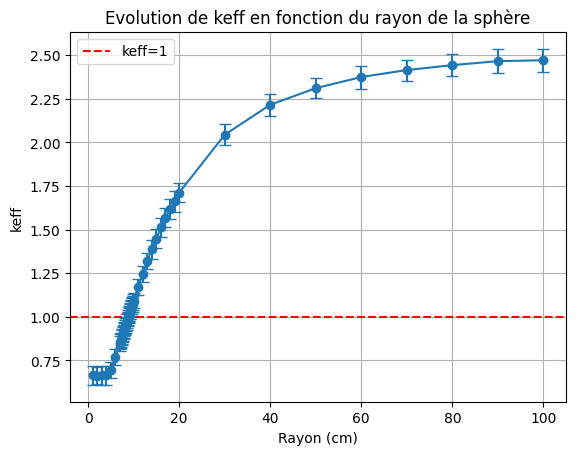

In [ ]:
fichier = open("masse_critique.txt", "r")
lignes = fichier.readlines()
fichier.close()

Trayon=[]
Tkeff=[]
for ligne in lignes[1:]:
    elements = ligne.split(";")
    Trayon.append(float(elements[0]))
    Tkeff.append((float(elements[1]), float(elements[2])))


import matplotlib.pyplot as plt

# Affichage des resultats avec barres d'erreur
plt.errorbar(Trayon, [keff[0] for keff in Tkeff], yerr=[keff[1] for keff in Tkeff], fmt='o-', capsize=4)
plt.axhline(1, color='r', linestyle='--', label='keff=1')
plt.title("Evolution de keff en fonction du rayon de la sphère")
plt.xlabel("Rayon (cm)")
plt.ylabel("keff")
plt.grid()
plt.legend()
plt.show()


On voit que k est saturé entre 0.6 et 2.5. On retrouve la saturation par $ \nu $ en borne inférieur ce qui est logique car on ne peut pas avoir plus de neutron que ce que produit en moyenne une fission.

Je ne suis pas capable d'expliquer la borne inférieur. Car je pense que cela est possible que tous les neutrons soit capturés mais c'est très peu probable.

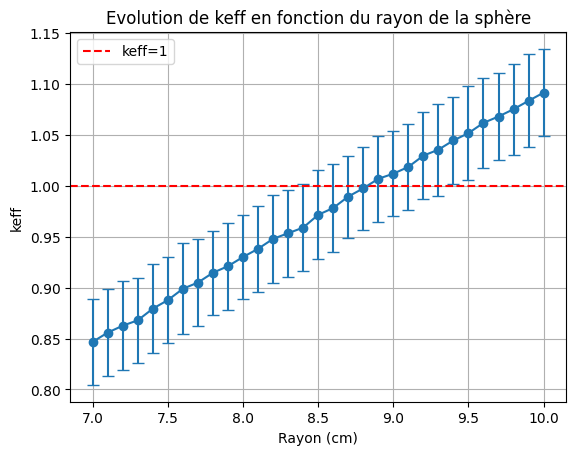

In [ ]:
import matplotlib.pyplot as plt

# Affichage des resultats avec barres d'erreur
plt.errorbar(Trayon[6:37], [keff[0] for keff in Tkeff[6:37]], yerr=[keff[1] for keff in Tkeff[6:37]], fmt='o-', capsize=4)
plt.axhline(1, color='r', linestyle='--', label='keff=1')
plt.title("Evolution de keff en fonction du rayon de la sphère")
plt.xlabel("Rayon (cm)")
plt.ylabel("keff")
plt.grid()
plt.legend()
plt.show()

In [6]:
rayon=8.8 # cm
volume_sphere = (4/3) * np.pi * rayon**3  # cm^3
density_uranium235 = 19.05  # g/cm^3
mass_critique = volume_sphere * density_uranium235  # g
print(f"Masse critique pour un rayon de {rayon} cm : {mass_critique:.2f} g")

Masse critique pour un rayon de 8.8 cm : 54379.05 g


Avec ce zoom sur les valeurs proche du rayon critique, on peut voir que 8.8 cm est celui qui correspond au mieux à $k_{eff}=1 $. Cela revient à une masse critique de 54 kg ce qui est assez proche de nos informations issus d'internet.

# Flux

# Première idée : étudier la position des neutrons

Ma première idée est de tracer un histogramme des distance depuis le centre de chacun des neutrons. Je pensais que en faisant la différence entre deux histogrammes, on ferait appraître le flux. Mais cela ne fonctionne pas car on a des mouvement vers l'extérieur et vers l'intérieur donc la différence est presque nulle.

100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


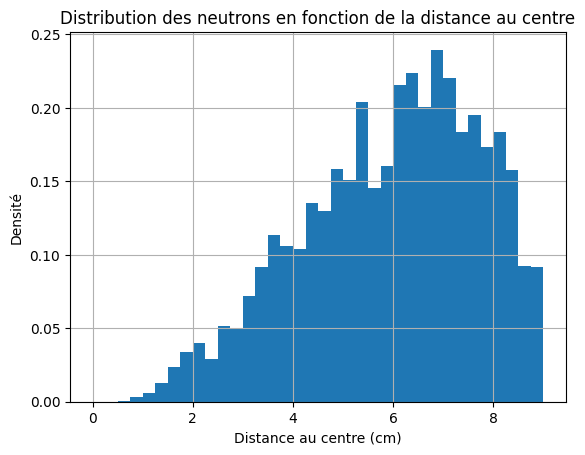

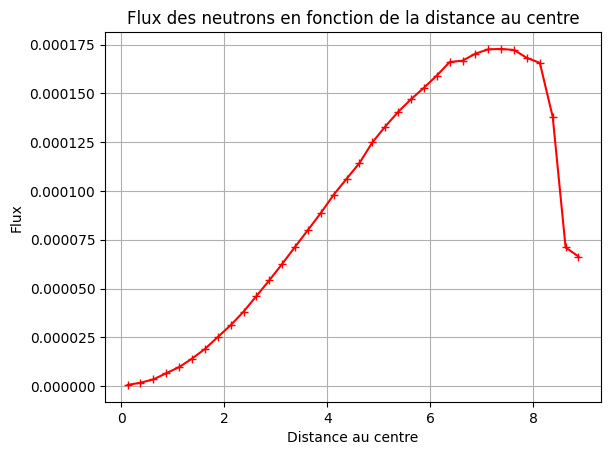

In [5]:
rayon=8.8
norme_neutrons=[]
pas=0.25
histogramme_0=np.zeros(len(np.arange(0, rayon+pas, pas))-1)
flux=np.zeros(len(np.arange(0, rayon+pas, pas))-1)

nb_batches = 200

for i in tqdm(range(nb_batches)):
    output_neutrons = []
    norme_neutrons=[]

    with Pool(processes) as pool:
        results = pool.map(simulate_neutron, starting_neutrons)
    output_neutrons = [n for sub in results for n in sub]

    for neutron in output_neutrons:
        norme_neutrons.append(np.linalg.norm(neutron.position))
    
    histogramme, _=np.histogram(norme_neutrons, bins=np.arange(0, rayon+pas, pas), density=True)
    flux+=(histogramme-histogramme_0)/nb_batches

    starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]

plt.hist(norme_neutrons, bins=np.arange(0, rayon+pas, pas), density=True)
plt.title("Distribution des neutrons en fonction de la distance au centre")
plt.xlabel("Distance au centre (cm)")
plt.ylabel("Densité")
plt.grid()
plt.show()

volume=4/3 * np.pi * (np.arange(0.1, rayon+pas, pas)**3 - np.arange(0, rayon, pas)**3)
flux/=np.sum(volume)  # Normalisation

plt.plot(np.arange(0, rayon, pas)+pas/2, flux,'r+-')
plt.xlabel("Distance au centre")
plt.ylabel("Flux")
plt.title("Flux des neutrons en fonction de la distance au centre")
plt.grid()
plt.show()


## Deuxième méthode : étudier le mouvement de chaque neutron.

(L'idée est issu de Nicolas Guillou)

L'idée est d'étudier chaque mouvement du neutron en ajoutant un +1 à à chaque case au milieu du mouvement.

On découpe le sphère en une grille. Pour chaque mouvement élastique, on détermine le milieu et on ajoute la norme (qui représente la puissance du mouvement) pour dire qu'il y a eu un passage.

Cela nous permet de faire une belle carte du mouvement des neutrons qui est bien plus logique que le résultat précédent.

100%|██████████| 1000/1000 [11:34<00:00,  1.44it/s]


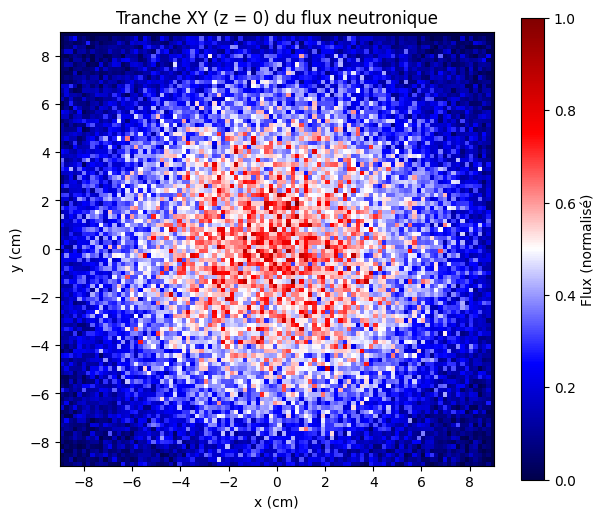

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def simulate_neutron_flux(neutron, data, grid_flux, x, y, z):
    
    # On choisit l'interaction
    distance = sample_distance_to_interaction(data.get_macro_xs("total"))
    old_pos = neutron.position.copy()
    neutron.move_distance(distance)
    new_pos = neutron.position.copy()
    calcul_flux(old_pos, new_pos, grid_flux, x, y, z)

    interaction=data.sample_interaction()
    while interaction == 'elastic':
        distance = sample_distance_to_interaction(data.get_macro_xs("total"))
        old_pos = neutron.position.copy()
        neutron.move_distance(distance)
        new_pos = neutron.position.copy()

        calcul_flux(old_pos, new_pos, grid_flux, x, y, z)
        # ------------------------------

        # On verifie si le neutron est sorti de la boule
        if geometry.neutron_in_sphere(neutron.position)==False:
            return [] # Si il est sorti, il est mort

        # On choisit la nouvelle direction
        neutron.set_direction(sample_uniform_direction())
        interaction = data.sample_interaction()
    
    
    if interaction=='fission': # Si c'est une fission, on crée de nouveaux neutrons
        new_neutron=[Neutron(neutron.position.copy(), sample_uniform_direction()) for _ in range(np.random.poisson(data.nu_bar))]
        return new_neutron
    
    if interaction=='capture': # Si c'est une capture, le neutron disparait
        return []
    
    assert False, "Erreur, pas d'interaction"



def calcul_flux(old_pos, new_pos, grid, x, y, z):
    """
    Ajoute la longueur de trajet au point du milieu du segment.
    Cela correspond à ajouter le flux

    Args:
        old_pos (np.ndarray): position avant le déplacement
        new_pos (np.ndarray): position après le déplacement
        grid (np.ndarray): grille 3D pour stocker le flux
        x (np.ndarray): coordonnées x des bords des voxels
        y (np.ndarray): coordonnées y des bords des voxels
        z (np.ndarray): coordonnées z des bords des voxels
    """
    mid = 0.5 * (old_pos + new_pos)

    ix = np.searchsorted(x, mid[0]) - 1
    iy = np.searchsorted(y, mid[1]) - 1
    iz = np.searchsorted(z, mid[2]) - 1

    if (0 <= ix < len(x)-1 and 0 <= iy < len(y)-1 and 0 <= iz < len(z)-1):
        grid[ix, iy, iz] += np.linalg.norm(new_pos - old_pos)



rayon = 9
data = NuclearData()
geometry = GeometrySphere(radius=rayon)

nb_neutrons_per_batch = 10000
nb_batches = 1000

# ---- Grille 3D (100³ voxels) ----
N = 100
x = np.linspace(-rayon, rayon, N)
y = np.linspace(-rayon, rayon, N)
z = np.linspace(-rayon, rayon, N)
grid_flux = np.zeros((N, N, N))

# génération initiale
starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction())  
                     for _ in range(nb_neutrons_per_batch)]

for batch in tqdm(range(nb_batches)):
    output_neutrons = []

    for neutron in starting_neutrons:
        new_neutrons = simulate_neutron_flux(neutron, data, grid_flux, x, y, z)
        output_neutrons += new_neutrons

    # renormalisation population
    starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]

# Trouver l’indice iz correspondant à z = 0 pour prendre une tranche passant par le centre
iz0 = np.abs(z - 0.0).argmin()

# Extraire la tranche XY à z = 0
flux_xy = grid_flux[:, :, iz0]

# Normalisation (pour affichage)
flux_xy_norm = flux_xy / flux_xy.max()

plt.figure(figsize=(7,6))
plt.imshow(flux_xy_norm.T,origin='lower',extent=[x[0], x[-1], y[0], y[-1]],cmap='seismic')
plt.colorbar(label="Flux (normalisé)")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.title("Tranche XY (z = 0) du flux neutronique")
plt.show()

Sur la carte ce dessus, on voit bien que le flux est important au centre et diminue quand on s'éloigne du bord.


# Troisième méthode : formule issu du cours


On ajoute $ \frac{1}{\Sigma_t}$ dans la case ou il y a une collision

100%|██████████| 1000/1000 [10:19<00:00,  1.61it/s]


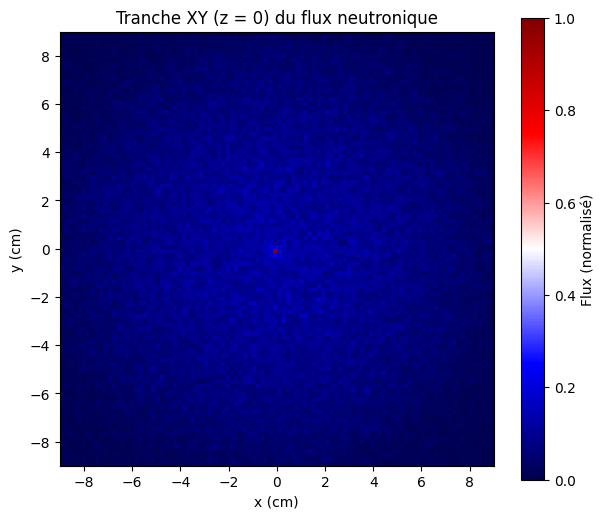

In [3]:
from mpl_toolkits.mplot3d import Axes3D

def simulate_neutron_flux(neutron, data, grid_flux, x, y, z):
    
    # On choisit l'interaction
    distance = sample_distance_to_interaction(data.get_macro_xs("total"))
    neutron.move_distance(distance)
    calcul_flux(neutron.position, grid_flux, x, y, z, data.get_macro_xs("total"))

    interaction=data.sample_interaction()
    while interaction == 'elastic':
        distance = sample_distance_to_interaction(data.get_macro_xs("total"))

        neutron.move_distance(distance)
        calcul_flux(neutron.position, grid_flux, x, y, z, data.get_macro_xs("total"))


        # On verifie si le neutron est sorti de la boule
        if geometry.neutron_in_sphere(neutron.position)==False:
            return [] # Si il est sorti, il est mort

        # On choisit la nouvelle direction
        neutron.set_direction(sample_uniform_direction())
        interaction = data.sample_interaction()
    
    
    if interaction=='fission': # Si c'est une fission, on crée de nouveaux neutrons
        new_neutron=[Neutron(neutron.position.copy(), sample_uniform_direction()) for _ in range(np.random.poisson(data.nu_bar))]
        return new_neutron
    
    if interaction=='capture': # Si c'est une capture, le neutron disparait
        return []
    
    assert False, "Erreur, pas d'interaction"



def calcul_flux(pos, grid, x, y, z, sigma_t):
    """
    Ajoute la longueur de trajet au point du milieu du segment.
    Cela correspond à ajouter le flux

    Args:
        old_pos (np.ndarray): position avant le déplacement
        new_pos (np.ndarray): position après le déplacement
        grid (np.ndarray): grille 3D pour stocker le flux
        x (np.ndarray): coordonnées x des bords des voxels
        y (np.ndarray): coordonnées y des bords des voxels
        z (np.ndarray): coordonnées z des bords des voxels
    """

    ix = np.searchsorted(x, pos[0]) - 1
    iy = np.searchsorted(y, pos[1]) - 1
    iz = np.searchsorted(z, pos[2]) - 1
    if (0 <= ix < len(x)-1 and 0 <= iy < len(y)-1 and 0 <= iz < len(z)-1):
        grid[ix, iy, iz] += 1/sigma_t



rayon = 9
data = NuclearData()
geometry = GeometrySphere(radius=rayon)

nb_neutrons_per_batch = 10000
nb_batches = 1000

# ---- Grille 3D (100³ voxels) ----
N = 100
x = np.linspace(-rayon, rayon, N)
y = np.linspace(-rayon, rayon, N)
z = np.linspace(-rayon, rayon, N)
grid_flux = np.zeros((N, N, N))

# génération initiale
starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction())  
                     for _ in range(nb_neutrons_per_batch)]

for batch in tqdm(range(nb_batches)):
    output_neutrons = []

    for neutron in starting_neutrons:
        new_neutrons = simulate_neutron_flux(neutron, data, grid_flux, x, y, z)
        output_neutrons += new_neutrons

    # renormalisation population
    starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]

# Trouver l’indice iz correspondant à z = 0 pour prendre une tranche passant par le centre
iz0 = np.abs(z - 0.0).argmin()

# Extraire la tranche XY à z = 0
flux_xy = grid_flux[:, :, iz0]

# Normalisation (pour affichage)
flux_xy_norm = flux_xy / flux_xy.max()

plt.figure(figsize=(7,6))
plt.imshow(flux_xy_norm.T,origin='lower',extent=[x[0], x[-1], y[0], y[-1]],cmap='seismic')
plt.colorbar(label="Flux (normalisé)")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.title("Tranche XY (z = 0) du flux neutronique")
plt.show()

/tmp/ipykernel_7718/1670828417.py:2: RuntimeWarning: divide by zero encountered in log
  log_flux = np.log(flux_xy.T)


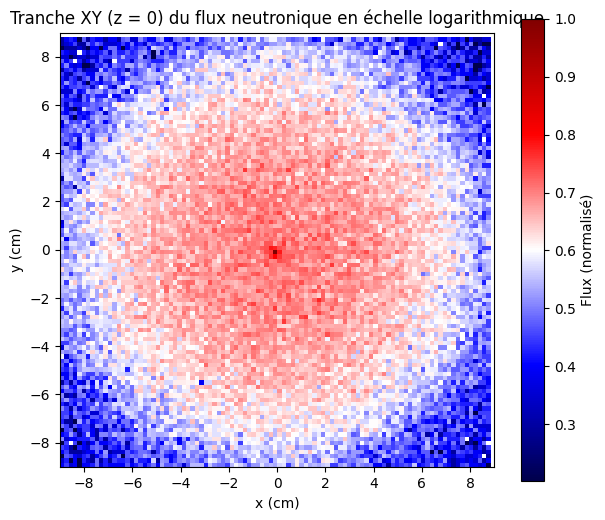

In [5]:
# flux en log
log_flux = np.log(flux_xy.T)
log_flux = log_flux/log_flux.max()

plt.figure(figsize=(7,6))
plt.imshow(log_flux,origin='lower',extent=[x[0], x[-1], y[0], y[-1]],cmap='seismic')
plt.colorbar(label="Flux (normalisé)")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.title("Tranche XY (z = 0) du flux neutronique en échelle logarithmique")
plt.show()

# Fuites

On se place dans une sphère avec de rayon critique (8.8cm). Nous allons chercher à déterminer le nombre de neutrons qui sort de la boule.

In [15]:
global nb_neutron_sortis
nb_neutron_sortis=0

def simulate_neutron(neutron):
    """
    Simulate the life of a neutron. 
    Eventually return fission neutrons in a list if a fission happened
    """

    # On choisit l'interaction
    distance = sample_distance_to_interaction(data.get_macro_xs("total"))
    neutron.move_distance(distance)

    interaction=data.sample_interaction()
    while interaction == 'elastic':
        distance = sample_distance_to_interaction(data.get_macro_xs("total"))
        neutron.move_distance(distance)

        # On verifie si le neutron est sorti de la boule
        if geometry.neutron_in_sphere(neutron.position)==False:
            global nb_neutron_sortis
            nb_neutron_sortis+=1
            # assert False, "Neutron sorti de la sphère"
            return [] # Si il est sorti, il est mort

        # On choisit la nouvelle direction
        neutron.set_direction(sample_uniform_direction())
        interaction = data.sample_interaction()
    
    
    if interaction=='fission': # Si c'est une fission, on crée de nouveaux neutrons
        new_neutron=[Neutron(neutron.position.copy(), sample_uniform_direction()) for _ in range(np.random.poisson(data.nu_bar))]
        return new_neutron
    
    if interaction=='capture': # Si c'est une capture, le neutron disparait
        return []
    
    assert False, "Erreur, pas d'interaction"



def calculer_keff(rayon, nb_batches=250, nb_neutrons_per_batch=10000):
    """ Calcul de keff pour une sphère de rayon donné

    Args:
        rayon (float): rayon de la sphère
        nb_batches (int, optional): nombre de lots. Defaults to 110.
        nb_neutrons_per_batch (int, optional): nombre de neutrons par lot. Defaults to 10000.
    """
    np.random.seed(0)

    starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction()) for i in range(nb_neutrons_per_batch)]
    keff = np.zeros(nb_batches)
    global data, geometry
    data = NuclearData()
    geometry = GeometrySphere(radius=rayon)

    # for i in tqdm(range(nb_batches)): # Affichage de la barre de progression
    for i in range(nb_batches):
        output_neutrons = []

        for neutron in starting_neutrons:
            new_neutrons = simulate_neutron(neutron)
            output_neutrons += new_neutrons

        # Parallélisation des calculs
        # with Pool(processes) as pool:
        #     results = pool.map(simulate_neutron, starting_neutrons)
        # output_neutrons = [n for sub in results for n in sub]


        # deepcopy qui est plus efficace que copy et qui résoud les problèmes de références
        starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]


# rayon pour démarrer
rayon = 8.8  # cm
np.random.seed(0)

data = NuclearData()
geometry = GeometrySphere(radius=rayon)
nb_neutrons_per_batch = 10000
nb_batches = 100
starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction()) for i in range(nb_neutrons_per_batch)]

calculer_keff(rayon,nb_batches=nb_batches)
# on normalise par le nombre de batchs.
nb_neutron_sortis /= nb_batches
print("Nombre de neutrons sortis de la sphère de rayon {:.2f} cm : {}".format(rayon, nb_neutron_sortis))


Nombre de neutrons sortis de la sphère de rayon 8.80 cm : 6038.88


Nous avons 60% des particules qui sortent de la sphère (ce qui est élévé).

# Impact du nombre de batches sur l'écart-type.

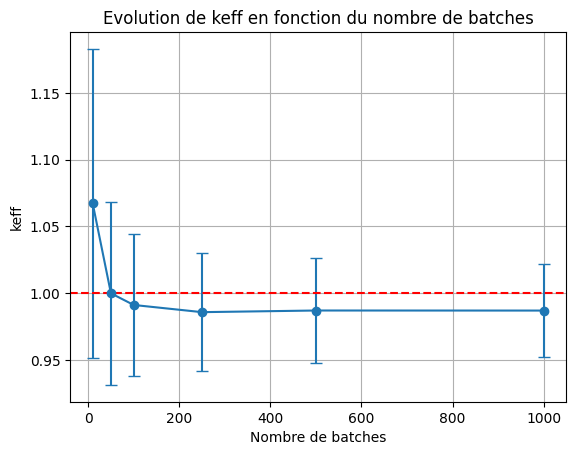

In [ ]:
rayon=8.7
Tkeff=[]
N_batches=[10,50,100,250,500,1000]

for batches in N_batches:
    keff = calculer_keff(rayon, nb_batches=batches)
    Tkeff.append(keff)
    
import matplotlib.pyplot as plt
# Affichage des resultats avec barres d'erreur
plt.errorbar(N_batches, [keff[0] for keff in Tkeff], yerr=[keff[1] for keff in Tkeff], fmt='o-', capsize=4)
plt.axhline(1, color='r', linestyle='--', label='keff=1')
plt.title("Evolution de keff en fonction du nombre de batches")
plt.xlabel("Nombre de batches")
plt.ylabel("keff")
plt.grid()
plt.show()

# Calculer le flux

# Milieu infini à 2 groupes
On reprend les deux équations faites dans la feuille 3.
 $g=1 $ : 
 
$$ \Sigma^1_t \psi_1=\Sigma^{1,1}_s \psi_1- \Sigma^{1,2}_s  \psi_1+\frac{1}{k}(\nu_1\Sigma^1_f\psi_1 + \nu_2\Sigma^2_f\psi_2 ) $$

$g=2$ : 
 
 $$ \Sigma^2_t \psi_2=\Sigma^{1,2}_s \psi_1 + \Sigma^{2,2}_s \psi_2 $$

Nous allons reprendre la structure précédente mais en ajoutant deux groupes (donc une valeur d'énergie dans à chaque neutron qui vaut 1 pour le groupe 1 et 2 pour le groupe 2).

De plus nous allons ajouter la diffusion. Cela va correspondre au changement de groupe. La diffusion élastique restera le terme élastique. On arrêtera l'évolution du neutron lors du changement de groupe (comme en cas de fission et de capture) et on retournera le neutron en le faisant changer de groupe. 

Il n'y aura que de la diffusion du groupe 1 vers 2 (la probabilité de diffusion du groupe 2 vaut 0) et tous les neutrons issus de fission iront dans le groupe 1.

On se pose dans un milieu supposé infini. Je choisis arbitrairement une sphère qui vaut 100cm de rayon.

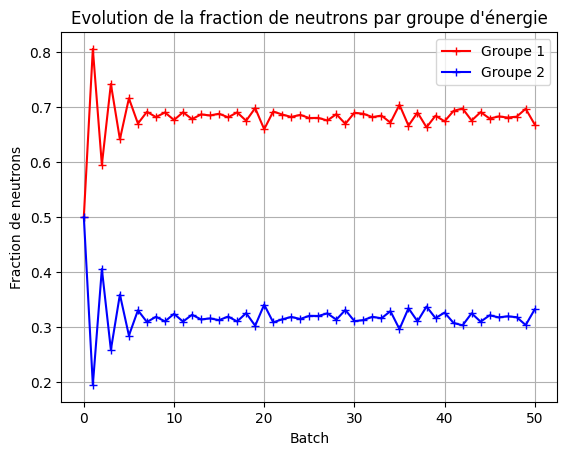

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from dataclasses import dataclass, field
import multiprocessing
from multiprocessing import Pool
processes=multiprocessing.cpu_count()

@dataclass
class Neutron:
    position: np.ndarray
    direction: np.ndarray
    energy: float

    def __post_init__(self):
        self._normalize_direction()

    def _normalize_direction(self):
        norm = np.linalg.norm(self.direction)
        self.direction /= norm
    
    def set_direction(self, vec):
        self.direction = vec
        self._normalize_direction()

    def move_distance(self, distance):
        self.position += self.direction * distance

def sample_distance_to_interaction(sigma_t):
    """
    Sample the distance to the next interaction from the total cross section
    """
    return -1/sigma_t * np.log(1-np.random.rand())

def sample_uniform_direction():
    """ Sample a uniform direction 
    """
    vec = np.random.uniform(-1, 1, 3)
    return vec / np.linalg.norm(vec)  

def simulate_neutron(neutron):
    """
    Simulate the life of a neutron. 
    Eventually return fission neutrons in a list if a fission happened
    """

    interactions=['elastic','fission','capture','diffusion'] # la diffusion correspond au changement de groupe d'énergie
    density: float = 4.4994e-02  
    Dictg1={'elastic':3.78266,'fission':1.2885,'capture':0.0599268,'diffusion':5,'nu_bar':2.64574,'total':(3.78266+1.2885+0.0599268+5)}

    Dictg2={'elastic':3.78266,'fission':1.2885,'capture':0.0599268,'diffusion':0,'nu_bar':2.64574,'total':(3.78266+1.2885+0.0599268)}

    probabilities=[
                    [Dictg1['elastic']/Dictg1['total'], Dictg1['fission']/Dictg1['total'], Dictg1['capture']/Dictg1['total'], Dictg1['diffusion']/Dictg1['total']],
                    [Dictg2['elastic']/Dictg2['total'], Dictg2['fission']/Dictg2['total'], Dictg2['capture']/Dictg2['total'], Dictg2['diffusion']/Dictg2['total']]
                    ]  
    
    # On choisit l'interaction
    sigma_t= density * (Dictg1['total'] if neutron.energy==1 else Dictg2['total'])    
    distance = sample_distance_to_interaction(sigma_t)
    neutron.move_distance(distance)

    interaction_selected = np.random.choice(interactions, p=probabilities[int(neutron.energy)-1])
    while interaction_selected == 'elastic':
        distance = sample_distance_to_interaction(sigma_t)
        neutron.move_distance(distance)

        # On verifie si le neutron est sorti de la boule
        if np.linalg.norm(neutron.position) > rayon:
            return [] # Si il est sorti, il est mort

        # On choisit la nouvelle direction
        neutron.set_direction(sample_uniform_direction())
        interaction_selected = np.random.choice(interactions, p=probabilities[int(neutron.energy)-1])
    
    
    if interaction_selected=='fission': # Si c'est une fission, on crée de nouveaux neutrons
        nu_bar=Dictg1['nu_bar'] if neutron.energy==1 else Dictg2['nu_bar']
        energie_neutron_post_fission=1  # On choisit que les neutrons de fission sont toujours dans le groupe 1
        new_neutron=[Neutron(neutron.position.copy(), sample_uniform_direction(), energie_neutron_post_fission) for _ in range(np.random.poisson(nu_bar))]
        return new_neutron
    
    if interaction_selected=='capture': # Si c'est une capture, le neutron disparait
        return []
    
    if interaction_selected=='diffusion': # Si c'est une diffusion, on change l'énergie du neutron pour passer dans l'autre groupe
        neutron.energy = 2 if neutron.energy == 1 else 1
        return [neutron]
    
    assert False, "Erreur, pas d'interaction"


np.random.seed(0)
nb_neutrons_per_batch = 10000
nb_batches = 50 # 110
rayon = 100  # cm Le milieu est supposé infini pour cette simulation
starting_neutrons_1 = [Neutron(np.zeros(3), sample_uniform_direction(),1) for i in range(nb_neutrons_per_batch//2)]
starting_neutrons_2 = [Neutron(np.zeros(3), sample_uniform_direction(),2) for i in range(nb_neutrons_per_batch//2)]
starting_neutrons = starting_neutrons_1 + starting_neutrons_2

# On debute avec une moitié de neutrons dans chaque groupe d'énergie
L_nb_neutrons_g1=[len(starting_neutrons_1)/len(starting_neutrons)]
L_nb_neutrons_g2=[len(starting_neutrons_2)/len(starting_neutrons)]


for i in range(nb_batches):
    output_neutrons = []

    # # on fait évoluer chaque neutron (méthode non parallélisée)
    # for neutron in starting_neutrons:
    #     new_neutrons = simulate_neutron(neutron)
    #     output_neutrons += new_neutrons

    # Parallélisation des calculs
    with Pool(processes) as pool:
        results = pool.map(simulate_neutron, starting_neutrons)
    output_neutrons = [n for sub in results for n in sub]

    # Comptage du nombre de neutrons par groupe d'énergie et on le normalise par le nombre total de neutrons
    L_nb_neutrons_g1.append(len([neutron for neutron in output_neutrons if neutron.energy==1])/len(output_neutrons))
    L_nb_neutrons_g2.append(len([neutron for neutron in output_neutrons if neutron.energy==2])/len(output_neutrons))

    # # deepcopy qui est plus efficace que copy et qui résoud les problèmes de références
    starting_neutrons = [copy.deepcopy(neutron) for neutron in np.random.choice(output_neutrons, nb_neutrons_per_batch)]

plt.plot(L_nb_neutrons_g1,'r+-', label='Groupe 1')
plt.plot(L_nb_neutrons_g2,'b+-', label='Groupe 2')
plt.title("Evolution de la fraction de neutrons par groupe d'énergie")
plt.xlabel("Batch")
plt.ylabel("Fraction de neutrons")
plt.grid()
plt.legend()
plt.show()

On retouve un équilibre entre les deux groupes qui dépend des termes de diffusion et de fission. En effet, un neutron du groupe 1 va se diffuser dans le groupe 2 puis va fissionner pour aller dans le groupe 1. Le groupe 1 est plus important car à chaque fission, on génère 2 à 3 neutrons donc il faudrait réduire $\nu$ et augmenter le terme de diffusion $\Sigma_s^{1,2}$ pour inverser les courbes.